In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import tensorflow as tf
import requests
import os
from sklearn import datasets
from sklearn.preprocessing import normalize
from tensorflow.python.framework import ops
ops.reset_default_graph()
sess = tf.Session()

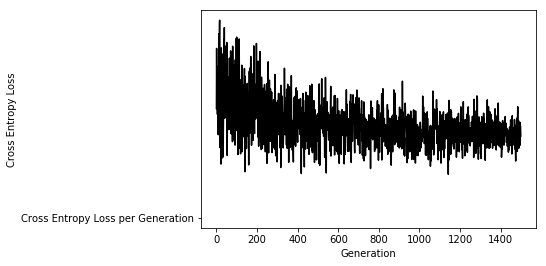

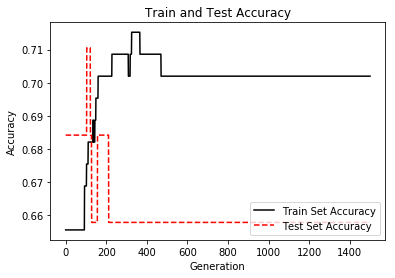

In [11]:
import csv

birth_weight_file = 'birth_weight.csv'
if not os.path.exists(birth_weight_file):
    birthdata_url = 'https://github.com/nfmcclure/tensorflow_cookbook/raw/master/01_Introduction/07_Working_with_Data_Sources/birthweight_data/birthweight.dat'
    birth_file = requests.get(birthdata_url)
    birth_data = birth_file.text.split('\r\n')
    birth_header = birth_data[0].split('\t')
    birth_data = [[float(x) for x in y.split('\t') if len(x) >= 1] for y in birth_data[1:] if len(y) >= 1]
    with open(birth_weight_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(birth_header)
        writer.writerows(birth_data)

# Read birth weight data into memory
birth_data = []
with open(birth_weight_file, newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    birth_header = next(csv_reader)
    for row in csv_reader:
        birth_data.append(row)
    birth_data = [[float(x) for x in row] for row in birth_data]

# Pull out target varaible
y_vals = np.array([x[0] for x in birth_data])
# Pull out predictor variables (not id, not target, and not birthweight)
x_vals = np.array([x[1:8] for x in birth_data])

train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

def normalize_cols(m, col_min=np.array([None]), col_max=np.array([None])):
    if not col_min[0]:
        col_min = m.min(axis=0)
    if not col_max[0]:
        col_max = m.max(axis=0)
    return (m - col_min) / (col_max - col_min), col_min, col_max

x_vals_train, train_min, train_max = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test, _, _ = np.nan_to_num(normalize_cols(x_vals_test, train_min, train_max))

batch_size = 25
x_data = tf.placeholder(shape=[None, 7], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
A = tf.Variable(tf.random_normal(shape=[7, 1]))
b = tf.Variable(tf.random_normal(shape=[1, 1]))
model_output = tf.add(tf.matmul(x_data, A), b)

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))
init = tf.global_variables_initializer()
sess.run(init)
opt = tf.train.GradientDescentOptimizer(0.01)
train_step = opt.minimize(loss)
prediction = tf.round(tf.sigmoid(model_output))
prediction_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(prediction_correct)

loss_vec = []
train_acc = []
test_acc = []
for i in range(1500):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    temp_acc_train = sess.run(accuracy, feed_dict={x_data: x_vals_train, y_target: np.transpose([y_vals_train])})
    train_acc.append(temp_acc_train)
    temp_acc_test = sess.run(accuracy, feed_dict={x_data: x_vals_test, y_target: np.transpose([y_vals_test])})
    test_acc.append(temp_acc_test)

plt.plot(loss_vec, 'k-')
plt.plot('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.show()
plt.plot(train_acc, 'k-', label='Train Set Accuracy')
plt.plot(test_acc, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()